# **Bus Need Classifier Preprocessing V7**

*Updates from V6: Cells have been further condensed and simplified, removing redundancies. RF has been chosen as the final model. One hot encoding pipeline has been removed for some variables to preserve current ordinal encoding in columns.*

This notebook is for preprocessing data from the 2017 National Household Travel Survey to train a classifier. The classifier will be able to identify whether a given student needs a school bus or not based on basic demographic information maintained by a school as well as information that can be derived from the student's address.

The codebook used for translating the survey's encodings can be found here: https://nhts.ornl.gov/documentation

The User Guide for interpreting survey data (including instructions on merging dataframes) can be found here: https://nhts.ornl.gov/media/2017/doc/NHTS2017_UsersGuide_04232019_1.pdf

Citation: Federal Highway Administration. (2017). 2017 National Household Travel Survey, U.S. Department of Transportation, Washington, DC. Available online: https://nhts.ornl.gov.

# **Data Cleaning**
We need to simplify our data into a usable table.

Import pandas and load in the three datasets (household, person, and trip) found at: https://nhts.ornl.gov/downloads from the 2017 CSV zip.

In [1]:
import pandas as pd
import numpy as np

hh = pd.read_csv('hhpub.csv')
person = pd.read_csv('perpub.csv')
trip = pd.read_csv('trippub.csv')

print("Household shape:", hh.shape)
print("Person shape:", person.shape)
print("Trip shape:", trip.shape)


Household shape: (129696, 58)
Person shape: (264234, 121)
Trip shape: (923572, 115)


In [2]:
hh.head()

,HOUSEID,TRAVDAY,SAMPSTRAT,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,PC,SPHONE,TAB,...,SMPLSRCE,WTHHFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,2,3,1,3,5,7,2,1,2,...,2,187.314320,T,50,1500,750,750,20,750,300
1,30000008,5,2,1,2,4,8,1,1,2,...,2,69.513032,R,5,300,300,150,5,300,300
2,30000012,5,3,1,1,2,10,1,1,3,...,2,79.419586,C,80,17000,17000,5000,60,17000,7000
3,30000019,5,3,1,2,2,3,1,5,5,...,2,279.143588,S,40,300,300,150,50,750,300
4,30000029,3,3,1,2,2,5,2,5,1,...,2,103.240304,S,40,1500,750,750,40,1500,750


In [3]:
person.head()

,HOUSEID,PERSONID,R_AGE,EDUC,R_HISP,R_RELAT,R_SEX,R_RACE,PRMACT,PAYPROF,...,SMPLSRCE,WTPERFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,1,67,3,2,1,2,2,6,2,...,2,206.690153,T,50,1500,750,750,20,750,300
1,30000007,2,66,3,2,2,1,2,1,-1,...,2,197.075742,T,50,1500,750,750,20,750,300
2,30000007,3,28,2,2,3,2,2,5,2,...,2,219.514210,T,50,1500,750,750,20,750,300
3,30000008,1,55,5,2,1,1,1,1,-1,...,2,63.185911,R,5,300,300,150,5,300,300
4,30000008,2,49,4,2,2,2,1,1,-1,...,2,58.665911,R,5,300,300,150,5,300,300


In [4]:
trip.head()

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,...,40,1500,750,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,20,750,300,40,1500,750,750,40,1500,750
4,30000007,3,1,845,900,15,2.250,3,0,0,...,20,750,300,50,750,300,350,60,750,300


Merge the PERSON and HOUSEHOLD dataframes onto the TRIP dataframe. TRIP will have the most rows (one for each trip), where one person/household may have taken several trips. So, duplicate rows in HOUSEHOLD and PERSON accordingly using HOUSEID and PERSONID as keys to merge these three together.

In [5]:
# Ensure key columns are same type (string) to avoid mismatches, then merge on both HOUSEID & PERSONID.
for df, cols in [(trip, ['HOUSEID','PERSONID']), (person, ['HOUSEID','PERSONID']), (hh, ['HOUSEID'])]:
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str)

# Merge Trip with Person using both keys (this will replicate person info for each trip)
trip_person = trip.merge(person, on=['HOUSEID','PERSONID'], how='left', suffixes=('_TRIP','_PERSON'))

# Merge with Household on HOUSEID (household info replicated for each trip/person row)
combined = trip_person.merge(hh, on='HOUSEID', how='left', suffixes=('','_HH'))

print("trip shape:", trip.shape)
print("trip_person shape:", trip_person.shape, "combined shape:", combined.shape)


trip shape: (923572, 115)
trip_person shape: (923572, 234) combined shape: (923572, 291)


Verify that the number of unique households, persons, and trips is maintained.

In [6]:
print("Unique households in original hh:", hh['HOUSEID'].nunique())
print("Unique persons in original person:", person[['HOUSEID','PERSONID']].drop_duplicates().shape[0])
print("Unique trips in original trip:", trip.shape[0])

print("\nAfter merge:")
print("Unique households in combined:", combined['HOUSEID'].nunique())
print("Unique persons in combined:", combined[['HOUSEID','PERSONID']].drop_duplicates().shape[0])
print("Total trip-person-household rows:", combined.shape[0])

hh_per_trip = combined['HOUSEID'].nunique() / combined.shape[0]
person_per_trip = combined[['HOUSEID','PERSONID']].drop_duplicates().shape[0] / combined.shape[0]

Unique households in original hh: 129696
Unique persons in original person: 264234
Unique trips in original trip: 923572

After merge:
Unique households in combined: 117222
Unique persons in combined: 219194
Total trip-person-household rows: 923572


Double check that the losses occured only due to reported households/persons that did NOT make any trips instead of faulty merging.

In [7]:
#Compare sets to see mismatch counts
trip_ids = set(trip['HOUSEID'].astype(str))
person_ids = set(person['HOUSEID'].astype(str))
hh_ids = set(hh['HOUSEID'].astype(str))

print("Trip households not in HH:", len(trip_ids - hh_ids))
print("Trip households not in Person:", len(trip_ids - person_ids))
print("Person households not in HH:", len(person_ids - hh_ids))


Trip households not in HH: 0
Trip households not in Person: 0
Person households not in HH: 0


In [8]:
# Households in HH not represented in any trip
hh_not_in_trip = set(hh['HOUSEID']) - set(trip['HOUSEID'])
print("Households in HH but not in Trip:", len(hh_not_in_trip))

# Persons in Person file not represented in any trip
person_pairs = set(zip(person['HOUSEID'], person['PERSONID']))
trip_pairs = set(zip(trip['HOUSEID'], trip['PERSONID']))
persons_not_in_trip = person_pairs - trip_pairs
print("Persons in Person but not in Trip:", len(persons_not_in_trip))


Households in HH but not in Trip: 12474
Persons in Person but not in Trip: 45040




*   129696 - 117222 = 12474
*   264234 - 219194 = 45040

All losses of households/persons only occur for households/persons with no trips taken.

Filter to only include trips made by people who attend school (filter the 'SCHTYP' column for 1's; derived from the codebook.)


**Limitation Note: This dataset was created by surveying (mostly) adults across the United States on the behaviour of their household members. As a result, there will be inherent mistakes from adults misreporting the travel activity of their children. There will also be inherent biases; students who are more likely to use a school bus due to adverse household environments are less likely to have parents who will participate in this survery, for example.**

In [9]:
student_trips = combined[combined['SCHTYP'] == 1].copy()

print("Original combined shape:", combined.shape)
print("Filtered school trips shape:", student_trips.shape)

Original combined shape: (923572, 291)
Filtered school trips shape: (89447, 291)


In [10]:
# Display first 10 rows of school trips to inspect
student_trips.head(10)

# Optional: see key columns for verification
student_trips[['HOUSEID','PERSONID','WHYTO','TRPMILES','TRVLCMIN']].head(10)


,HOUSEID,PERSONID,WHYTO,TRPMILES,TRVLCMIN
121,30000144,2,13,2.140,43
122,30000144,2,8,2.426,30
123,30000144,2,11,1.057,18
124,30000144,2,1,0.000,61
125,30000144,3,13,2.140,43
126,30000144,3,8,2.426,30
127,30000144,3,11,1.057,18
128,30000144,3,1,0.000,61
219,30000302,3,8,7.738,19
220,30000302,3,13,3.204,12


Keep only necessary columns. We want columns that capture information about a student that can reasonabely be gathered or estimated from their address and demographics (urban/rural classification, geographic area, etc.).

In [37]:
# List of feasible columns including identifiers

feasible_columns = [
    'HOUSEID',
    'PERSONID',
    'TRPMILES',
    'SCHTRN1',
    'WHYTO',

    #ordinal categorical labeling
    "DBHTNRNT", #% of renter-occupied housing in block group (destination of a trip)
    "DBPPOPDN", #population density in block group
    "DBRESDN",  #housing units per sq mile in block group
    "DTEEMPDN", #workers per square mile in tract
    "DTHTNRNT", #% of renter-occupied housing in tract
    "DTPPOPDN", #population density in tract
    "DTRESDN",  #housing units per sq mile in tract

    "OBHTNRNT", #same info, but for origin location of a trip
    "OBPPOPDN",
    "OBRESDN",
    "OTEEMPDN",
    "OTHTNRNT",
    "OTPPOPDN",
    "OTRESDN",

    #nominal categorical labeling
    "CENSUS_D", #census division
    "HHFAMINC",
    "HH_RACE",
    "HH_HISP",
    "MSASIZE", #size of metropolitan statistical area (or none)
    "URBRUR", #urban or rural
]


# Filter the dataframe
student_trips_filtered = student_trips[feasible_columns].copy()

# Preview
print("Filtered dataframe shape:", student_trips_filtered.shape)
student_trips_filtered.head()


Filtered dataframe shape: (89447, 25)


,HOUSEID,PERSONID,TRPMILES,SCHTRN1,WHYTO,DBHTNRNT,DBPPOPDN,DBRESDN,DTEEMPDN,DTHTNRNT,...,OTEEMPDN,OTHTNRNT,OTPPOPDN,OTRESDN,CENSUS_D,HHFAMINC,HH_RACE,HH_HISP,MSASIZE,URBRUR
121,30000144,2,2.140,11,13,30,7000,3000,3000,30,...,1500,30,3000,750,7,5,2,2,5,1
122,30000144,2,2.426,11,8,80,7000,1500,1500,80,...,3000,30,7000,3000,7,5,2,2,5,1
123,30000144,2,1.057,11,11,50,7000,3000,5000,70,...,1500,80,7000,1500,7,5,2,2,5,1
124,30000144,2,0.000,11,1,70,7000,3000,1500,30,...,5000,70,17000,7000,7,5,2,2,5,1
125,30000144,3,2.140,11,13,30,7000,3000,3000,30,...,1500,30,3000,750,7,5,2,2,5,1


Check for null values according to the survey's encoding:

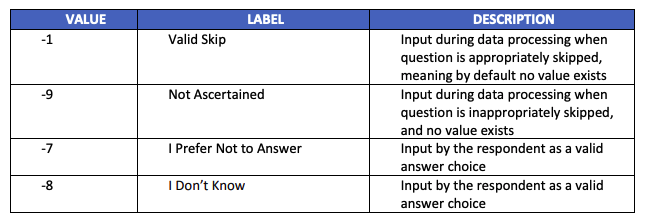

In [38]:
# Define the nonresponse codes
nonresponse_codes = [-1, -7, -8, -9]

# Initialize a dataframe to store counts
nonresponse_counts = pd.DataFrame(columns=['Column_Name', '-1', '-7', '-8', '-9'])

# Loop through each column and count nonresponse values
for col in student_trips_filtered.columns:
    counts = student_trips_filtered[col].isin(nonresponse_codes).groupby(student_trips_filtered[col]).sum()
    row = {
        'Column_Name': col,
        '-1': (student_trips_filtered[col] == -1).sum(),
        '-7': (student_trips_filtered[col] == -7).sum(),
        '-8': (student_trips_filtered[col] == -8).sum(),
        '-9': (student_trips_filtered[col] == -9).sum()
    }
    nonresponse_counts = pd.concat([nonresponse_counts, pd.DataFrame([row])], ignore_index=True)

# Show counts
nonresponse_counts

,Column_Name,-1,-7,-8,-9
0,HOUSEID,0,0,0,0
1,PERSONID,0,0,0,0
2,TRPMILES,0,0,0,89
3,SCHTRN1,0,19,4,7
4,WHYTO,0,26,4,1
5,DBHTNRNT,0,0,0,68
6,DBPPOPDN,0,0,0,68
7,DBRESDN,0,0,0,68
8,DTEEMPDN,0,0,0,67
9,DTHTNRNT,0,0,0,67


To simplify this, let's just drop all rows with a "null" value.

In [39]:
# List of columns you want to check
variables = student_trips_filtered.columns

# Drop rows where ANY of those columns contains -9
student_trips_filtered_clean = student_trips_filtered[~student_trips_filtered[variables].eq(-9).any(axis=1)].copy()

# Optional: print how many rows were removed
removed = len(student_trips_filtered) - len(student_trips_filtered_clean)
print(f"Removed {removed} rows that contained -9 in any specified column.")

student_trips_filtered = student_trips_filtered_clean

# Reset index after dropping rows
student_trips_filtered = student_trips_filtered.reset_index(drop=True)

# Confirm changes
print(student_trips_filtered.shape)
student_trips_filtered['SCHTRN1'].value_counts()


Removed 204 rows that contained -9 in any specified column.
(89243, 25)


,count
SCHTRN1,
3,31291
10,25737
4,13650
1,6549
5,5382
6,3690
2,1484
11,577
97,275


Clean up repeats, since one student may have taken multiple trips (multiple rows), including trips that are unrelated to school.

* Create a new column called 'SCHOOL_DISTANCE' with blank values.

* Among each group of "similar" rows, find all rows where 'WHYTO' == 8 (indicates the trip was to go to school).

* Take the median value for 'TRPMILES' for all of these rows and fill that value in for the 'SCHOOL_DISTANCE' column for all these rows.

* If there are no rows where 'WHYTO' == 8, do nothing.

* Drop the 'WHYTO', 'HOUSEID', 'PERSONID' columns.

* Drop all repeat occurences of rows with the same HOUSEID and PERSONID.

* For all rows with a 0 in the 'SCHOOL_DISTANCE' column, fill in with the median value of the column.

* Drop TRPMILES.

In [40]:
# Make a copy to be safe
student_trips_filtered = student_trips_filtered.copy()

# Step 1: Create a blank SCHOOL_DISTANCE column
student_trips_filtered['SCHOOL_DISTANCE'] = np.nan

# Step 2: For each (HOUSEID, PERSONID) group, fill SCHOOL_DISTANCE with the median TRPMILES where WHYTO == 8
def assign_school_time_distance(group):

    school_trips = group[group['WHYTO'] == 8]['TRPMILES']
    if not school_trips.empty:
        median_distance = school_trips.median()
        group['SCHOOL_DISTANCE'] = median_distance

    return group

# Also groups "similar rows" together
student_trips_filtered = student_trips_filtered.groupby(['HOUSEID', 'PERSONID'], group_keys=False).apply(assign_school_time_distance)

# Step 3: Drop the WHYTO column
student_trips_filtered = student_trips_filtered.drop(columns=['WHYTO'])

# Step 4: Drop duplicate rows with same HOUSEID and PERSONID (keep the first)
student_trips_filtered = student_trips_filtered.drop_duplicates(subset=['HOUSEID', 'PERSONID'])

# Step 5: Fill SCHOOL_DISTANCE = 0 with the column median
median_distance = student_trips_filtered.loc[student_trips_filtered['SCHOOL_DISTANCE'] > 0, 'SCHOOL_DISTANCE'].median()
student_trips_filtered['SCHOOL_DISTANCE'] = student_trips_filtered['SCHOOL_DISTANCE'].replace(0, np.nan)
student_trips_filtered['SCHOOL_DISTANCE'] = student_trips_filtered['SCHOOL_DISTANCE'].fillna(median_distance)

#drop HOUSEID and PERSONID and TRPMILES columns
student_trips_filtered = student_trips_filtered.drop(columns=['HOUSEID'])
student_trips_filtered = student_trips_filtered.drop(columns=['PERSONID'])
student_trips_filtered = student_trips_filtered.drop(columns=['TRPMILES'])


# Step 6: Reset index
student_trips_filtered = student_trips_filtered.reset_index(drop=True)

# Confirm result
student_trips_filtered.shape
student_trips_filtered.head()


/tmp/ipython-input-332536790.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  student_trips_filtered = student_trips_filtered.groupby(['HOUSEID', 'PERSONID'], group_keys=False).apply(assign_school_time_distance)


,SCHTRN1,DBHTNRNT,DBPPOPDN,DBRESDN,DTEEMPDN,DTHTNRNT,DTPPOPDN,DTRESDN,OBHTNRNT,OBPPOPDN,...,OTHTNRNT,OTPPOPDN,OTRESDN,CENSUS_D,HHFAMINC,HH_RACE,HH_HISP,MSASIZE,URBRUR,SCHOOL_DISTANCE
0,11,30,7000,3000,3000,30,7000,3000,70,7000,...,30,3000,750,7,5,2,2,5,1,2.426
1,11,30,7000,3000,3000,30,7000,3000,70,7000,...,30,3000,750,7,5,2,2,5,1,2.426
2,3,5,750,300,350,5,750,300,0,3000,...,5,1500,750,7,11,1,2,5,1,7.738
3,10,20,7000,1500,1500,5,3000,1500,20,3000,...,5,3000,1500,6,8,1,2,4,1,15.403
4,10,80,3000,750,1500,50,3000,1500,50,3000,...,50,3000,1500,2,3,1,2,1,1,2.624


Quick check: how many unique students in our dataset usually use a school bus?

In [41]:
# Count how many students have SCHTRN1 == 10
mode_10_count = student_trips_filtered[student_trips_filtered['SCHTRN1'] == 10].shape[0]
total_students = student_trips_filtered.shape[0]

print(f"School trips with SCHTRN 10: {mode_10_count}")
print(f"Total students: {total_students}")
print(f"Percentage: {mode_10_count / total_students * 100:.2f}%")


School trips with SCHTRN 10: 7935
Total students: 26188
Percentage: 30.30%


Re encode the SCHTRN1 column to a binary NEEDS_SCHOOL_BUS column. Code 10 indicates the student usually takes a bus to school, and all other codes indicate other means of transport.

**Limitation Note: This process assumes that every student who uses a school bus needs a school bus, and that if a student doesn't usually use a bus they do not need a bus. This is not always correct in practice, since many students might not use a bus because of bad bus service, even if they actually need it. Future changes to address this limitation might be to more carefully analyze what other modes of transport students use and for how many miles to help determine which students NEED a bus vs actually USE a bus.**

In [42]:
# Re-encode the SCHTRN1 column to indicate "needs school bus"
# Original column: SCHTRN1
# Rule: 10 → 1 (needs school bus), everything else → 0

student_trips_filtered['NEEDS_SCHOOL_BUS'] = student_trips_filtered['SCHTRN1'].apply(lambda x: 1 if x == 10 else 0)

# Optional: drop the original SCHTRN1 column if no longer needed
student_trips_filtered = student_trips_filtered.drop(columns=['SCHTRN1'])

# Verify changes
student_trips_filtered[['NEEDS_SCHOOL_BUS']].head(30)

,NEEDS_SCHOOL_BUS
0,0
1,0
2,0
3,1
4,1
5,0
6,0
7,0
8,0
9,0


Remove the _TRIP suffix from all columns in student_trips_filtered that have the suffix.

In [43]:
# Remove '_TRIP' suffix from all column names
student_trips_filtered.columns = [col.replace('_TRIP', '') for col in student_trips_filtered.columns]
student_trips_filtered.head()

,DBHTNRNT,DBPPOPDN,DBRESDN,DTEEMPDN,DTHTNRNT,DTPPOPDN,DTRESDN,OBHTNRNT,OBPPOPDN,OBRESDN,...,OTPPOPDN,OTRESDN,CENSUS_D,HHFAMINC,HH_RACE,HH_HISP,MSASIZE,URBRUR,SCHOOL_DISTANCE,NEEDS_SCHOOL_BUS
0,30,7000,3000,3000,30,7000,3000,70,7000,3000,...,3000,750,7,5,2,2,5,1,2.426,0
1,30,7000,3000,3000,30,7000,3000,70,7000,3000,...,3000,750,7,5,2,2,5,1,2.426,0
2,5,750,300,350,5,750,300,0,3000,750,...,1500,750,7,11,1,2,5,1,7.738,0
3,20,7000,1500,1500,5,3000,1500,20,3000,1500,...,3000,1500,6,8,1,2,4,1,15.403,1
4,80,3000,750,1500,50,3000,1500,50,3000,1500,...,3000,1500,2,3,1,2,1,1,2.624,1


# **One Hot Encoding**
Almost all of our variables are categorical, but some of them are ordinal (population density, for example, has integer codings that maintain order and scale). We need to one-hot encode only the variables that currently have no meaningful ordinal encoding (according to the codebook):


*   HH_RACE
*   MSASIZE
*   HH_HISP
*   HHFAMINC

We will ignore CENSUS_D for now since it won't be part of our final model. We can also modify the URBRUR column to indicate 1 = Urban and 0 = Rural instead of one-hot encoding it.



In [44]:
student_trips_filtered["URBRUR"] = student_trips_filtered["URBRUR"].replace({2: 0})


First, download the codebook file and load it in. This codebook contains mappings for every code used for all categorical variables, as well as for some numerical variables.

In [45]:
# Load all sheets at once as a dictionary of DataFrames
all_sheets = pd.read_excel('codebook_v1.2.xlsx', sheet_name=None)

# Combine all sheets into one DataFrame
codebook_df = pd.concat(all_sheets.values(), ignore_index=True)

Forward fill the variable names so that each code is associated with a column variable name.

In [47]:
# Forward fill the 'Name' column so each code row knows its variable
codebook_df['Name'] = codebook_df['Name'].ffill()
codebook_df.head()

,Name,Code / Range
0,BIKE,-9=Not ascertained
1,BIKE,-8=I don't know
2,BIKE,-7=I prefer not to answer
3,BIKE,01=Daily
4,BIKE,02=A few times a week


Keep only the Name and Code / Range columns.

Our student_trips_filtered dataframe has column names based on the TRIPS file, which has _TRIPS appended to most of the column names. Clean up the column names in student_trips_filtered so they match the names in the codebook.

Filter the codebook so that only codes for variables we want to encode are preserved.

In [48]:
# Keep only the relevant columns
codebook_df = codebook_df[['Name', 'Code / Range']]

# Get only categorical columns
school_trip_cols = [
    "HHFAMINC",
    "HH_RACE",
    "HH_HISP",
    "MSASIZE"
]

# Clean up names to match between codebook and your df
# The codebook may use names like 'HHFAMINC' while the df uses 'HHFAMINC_TRIP'
# So we match ignoring trailing suffixes like '_TRIP'
base_names = [c.replace('_TRIP', '') for c in school_trip_cols]

# Filter the codebook so we only keep rows whose Name matches one of these
filtered_codebook = codebook_df[codebook_df['Name'].isin(base_names)].copy()

# Display the first few rows to confirm
filtered_codebook.head(20)

,Name,Code / Range
126,HHFAMINC,-9=Not ascertained
127,HHFAMINC,-8=I don't know
128,HHFAMINC,-7=I prefer not to answer
129,HHFAMINC,"01=Less than $10,000"
130,HHFAMINC,"02=$10,000 to $14,999"
131,HHFAMINC,"03=$15,000 to $24,999"
132,HHFAMINC,"04=$25,000 to $34,999"
133,HHFAMINC,"05=$35,000 to $49,999"
134,HHFAMINC,"06=$50,000 to $74,999"
135,HHFAMINC,"07=$75,000 to $99,999"


Remove the _TRIP suffix from all columns in student_trips_filtered that have the suffix.

In [49]:
# Remove '_TRIP' suffix from all column names
student_trips_filtered.columns = [col.replace('_TRIP', '') for col in student_trips_filtered.columns]
student_trips_filtered.head()

,DBHTNRNT,DBPPOPDN,DBRESDN,DTEEMPDN,DTHTNRNT,DTPPOPDN,DTRESDN,OBHTNRNT,OBPPOPDN,OBRESDN,...,OTPPOPDN,OTRESDN,CENSUS_D,HHFAMINC,HH_RACE,HH_HISP,MSASIZE,URBRUR,SCHOOL_DISTANCE,NEEDS_SCHOOL_BUS
0,30,7000,3000,3000,30,7000,3000,70,7000,3000,...,3000,750,7,5,2,2,5,1,2.426,0
1,30,7000,3000,3000,30,7000,3000,70,7000,3000,...,3000,750,7,5,2,2,5,1,2.426,0
2,5,750,300,350,5,750,300,0,3000,750,...,1500,750,7,11,1,2,5,1,7.738,0
3,20,7000,1500,1500,5,3000,1500,20,3000,1500,...,3000,1500,6,8,1,2,4,1,15.403,1
4,80,3000,750,1500,50,3000,1500,50,3000,1500,...,3000,1500,2,3,1,2,1,1,2.624,1


To one hot encode, we can create a mapping dictionary that maps integer codes present in each column of student_trips_filtered to their corresponding "human readable column names" in the codebook dataframe.

Keep in mind that the numerical codes in the codebook dataframe appear as strings, but are integer entries in  student_trips_filtered, so str->int conversion is needed to match them.

Finally, we can use pd.get_dummies to one hot encode all the categorical columns, rewriting the auto-generated column names to the human readable versions using the mapping dictionary.

In [50]:
# Step 1: Build mapping dictionary
mapping_dict = {}
for var in filtered_codebook['Name'].unique():
    subset = filtered_codebook[filtered_codebook['Name'] == var]['Code / Range'].dropna()
    var_map = {}
    for entry in subset:
        if '=' in entry:
            code, label = entry.split('=', 1)
            try:
                var_map[int(code.strip())] = label.strip()
            except ValueError:
                var_map[code.strip()] = label.strip()
    mapping_dict[var] = var_map

# Step 2: Convert categorical columns to int where possible
for col in mapping_dict.keys():
    if col in student_trips_filtered.columns:
        try:
            student_trips_filtered[col] = student_trips_filtered[col].astype(int)
        except ValueError:
            pass

# Step 3: Identify categorical vars (binary or not)
categorical_vars = [col for col in mapping_dict.keys() if col in student_trips_filtered.columns]

# Step 4: One-hot encode WITHOUT dropping dummies (Random Forest does not require drop_first)
onehot_df = pd.get_dummies(
    student_trips_filtered,
    columns=categorical_vars,
    prefix=categorical_vars,
    dtype=int,
    drop_first=False   # <--- changed here
)

# Step 5: Rename one-hot columns to human-readable labels
new_columns = []
for col in onehot_df.columns:
    matched = False
    for var, code_map in mapping_dict.items():
        for code, label in code_map.items():
            if col == f"{var}_{code}":
                new_columns.append(f"{var}_{label}")
                matched = True
                break
        if matched:
            break
    if not matched:
        new_columns.append(col)

onehot_df.columns = new_columns

onehot_df.head()


,DBHTNRNT,DBPPOPDN,DBRESDN,DTEEMPDN,DTHTNRNT,DTPPOPDN,DTRESDN,OBHTNRNT,OBPPOPDN,OBRESDN,...,HH_RACE_American Indian or Alaska Native,HH_RACE_Native Hawaiian or other Pacific Islander,HH_RACE_Multiple responses selected,HH_RACE_Some other race,"MSASIZE_In an MSA of Less than 250,000","MSASIZE_In an MSA of 250,000 - 499,999","MSASIZE_In an MSA of 500,000 - 999,999","MSASIZE_In an MSA or CMSA of 1,000,000 - 2,999,999",MSASIZE_In an MSA or CMSA of 3 million or more,MSASIZE_Not in MSA or CMSA
0,30,7000,3000,3000,30,7000,3000,70,7000,3000,...,0,0,0,0,0,0,0,0,1,0
1,30,7000,3000,3000,30,7000,3000,70,7000,3000,...,0,0,0,0,0,0,0,0,1,0
2,5,750,300,350,5,750,300,0,3000,750,...,0,0,0,0,0,0,0,0,1,0
3,20,7000,1500,1500,5,3000,1500,20,3000,1500,...,0,0,0,0,0,0,0,1,0,0
4,80,3000,750,1500,50,3000,1500,50,3000,1500,...,0,0,0,0,1,0,0,0,0,0


Verify the one hot encoding and renaming.

In [51]:
# Get the dimensions
print("Shape of the one-hot encoded dataframe:", onehot_df.shape)

# Print all column names neatly
print("Columns:")
for col in onehot_df.columns:
    print(col)


Shape of the one-hot encoded dataframe: (26188, 49)
Columns:
DBHTNRNT
DBPPOPDN
DBRESDN
DTEEMPDN
DTHTNRNT
DTPPOPDN
DTRESDN
OBHTNRNT
OBPPOPDN
OBRESDN
OTEEMPDN
OTHTNRNT
OTPPOPDN
OTRESDN
CENSUS_D
URBRUR
SCHOOL_DISTANCE
NEEDS_SCHOOL_BUS
HHFAMINC_I don't know
HHFAMINC_I prefer not to answer
HHFAMINC_Less than $10,000
HHFAMINC_$10,000 to $14,999
HHFAMINC_$15,000 to $24,999
HHFAMINC_$25,000 to $34,999
HHFAMINC_$35,000 to $49,999
HHFAMINC_$50,000 to $74,999
HHFAMINC_$75,000 to $99,999
HHFAMINC_$100,000 to $124,999
HHFAMINC_$125,000 to $149,999
HHFAMINC_$150,000 to $199,999
HHFAMINC_$200,000 or more
HH_HISP_Refused
HH_HISP_Yes
HH_HISP_No
HH_RACE_Don't know
HH_RACE_Refused
HH_RACE_White
HH_RACE_Black or African American
HH_RACE_Asian
HH_RACE_American Indian or Alaska Native
HH_RACE_Native Hawaiian or other Pacific Islander
HH_RACE_Multiple responses selected
HH_RACE_Some other race
MSASIZE_In an MSA of Less than 250,000
MSASIZE_In an MSA of 250,000 - 499,999
MSASIZE_In an MSA of 500,000 - 999,999

In [61]:
student_trips_filtered = onehot_df

Let's merge HHFAMINC_I don't know and HHFAMINC_I prefer not to answer into HHFAMINC_No data. We can do similar transformations on HH_RACE and HH_HISP

In [62]:
student_trips_filtered["HHFAMINC_No data"] = (
    student_trips_filtered["HHFAMINC_I don't know"] |
    student_trips_filtered["HHFAMINC_I prefer not to answer"]
).astype(int)

student_trips_filtered = student_trips_filtered.drop(
    columns=["HHFAMINC_I don't know", "HHFAMINC_I prefer not to answer"]
)


In [63]:
student_trips_filtered["HH_RACE_Other"] = (
    student_trips_filtered["HH_RACE_Multiple responses selected"] |
    student_trips_filtered["HH_RACE_Some other race"]
).astype(int)

student_trips_filtered = student_trips_filtered.drop(
    columns=["HH_RACE_Multiple responses selected", "HH_RACE_Some other race"]
)

In [64]:
student_trips_filtered["HH_RACE_No data"] = (
    student_trips_filtered["HH_RACE_Don't know"] |
    student_trips_filtered["HH_RACE_Refused"]
).astype(int)

student_trips_filtered = student_trips_filtered.drop(
    columns=["HH_RACE_Don't know", "HH_RACE_Refused"]
)

In [65]:
student_trips_filtered["HH_HISP_No data"] = student_trips_filtered["HH_HISP_Refused"]
student_trips_filtered = student_trips_filtered.drop(columns=["HH_HISP_Refused"])

student_trips_filtered["HH_HISP"] = student_trips_filtered["HH_HISP_Yes"]
student_trips_filtered = student_trips_filtered.drop(columns=["HH_HISP_Yes"])
student_trips_filtered = student_trips_filtered.drop(columns=["HH_HISP_No"])

# **Feature Engineering**
We want to maximize the signal for NEEDS_SCHOOL_BUS in our data, which may involve some transformations. We also want to minimize the complexity of our data to reduce overfitting.

Make a correlation matrix.

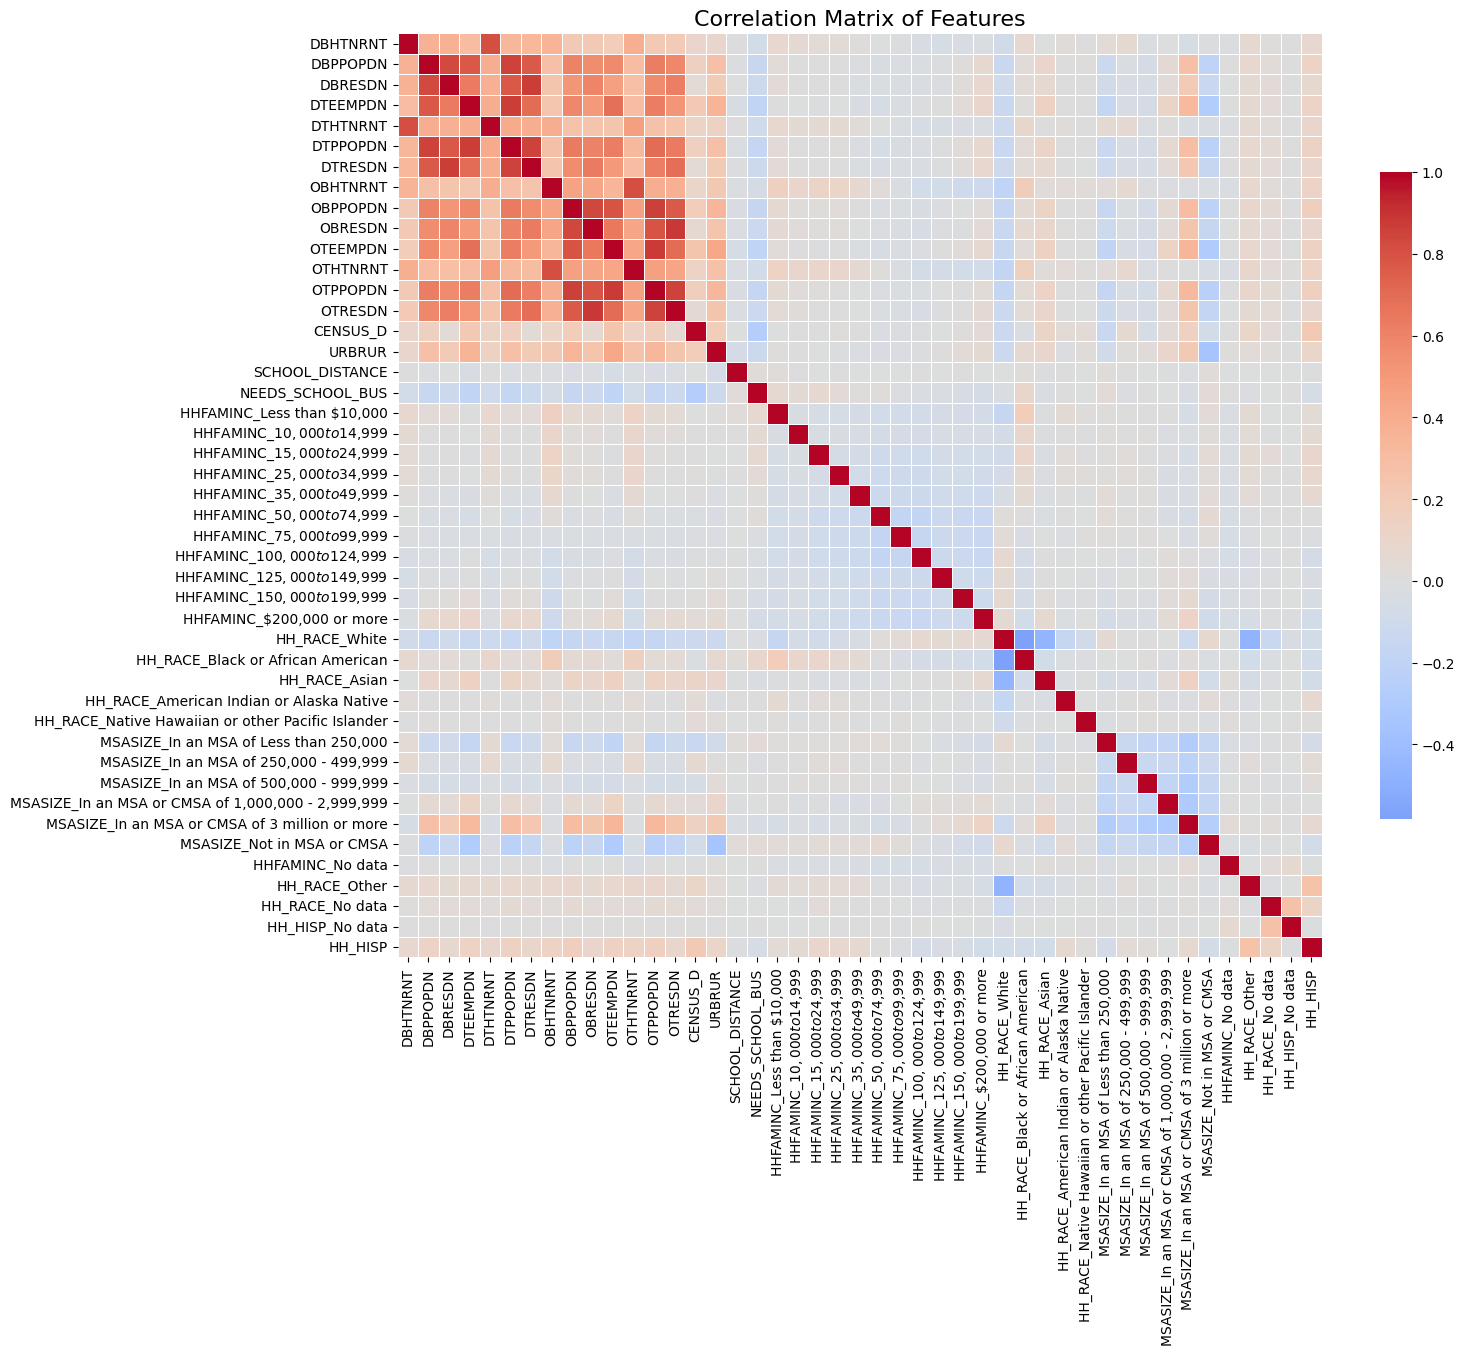

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = student_trips_filtered.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=False,  # True if you want the numbers on the heatmap
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.7})

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


It looks like theres a lot of redundancy within the first several variables. This is likely because many of them measure the same quantity at the tract level and block group level (which is often the same), as well as for the school's location and the house's location (also often the same).

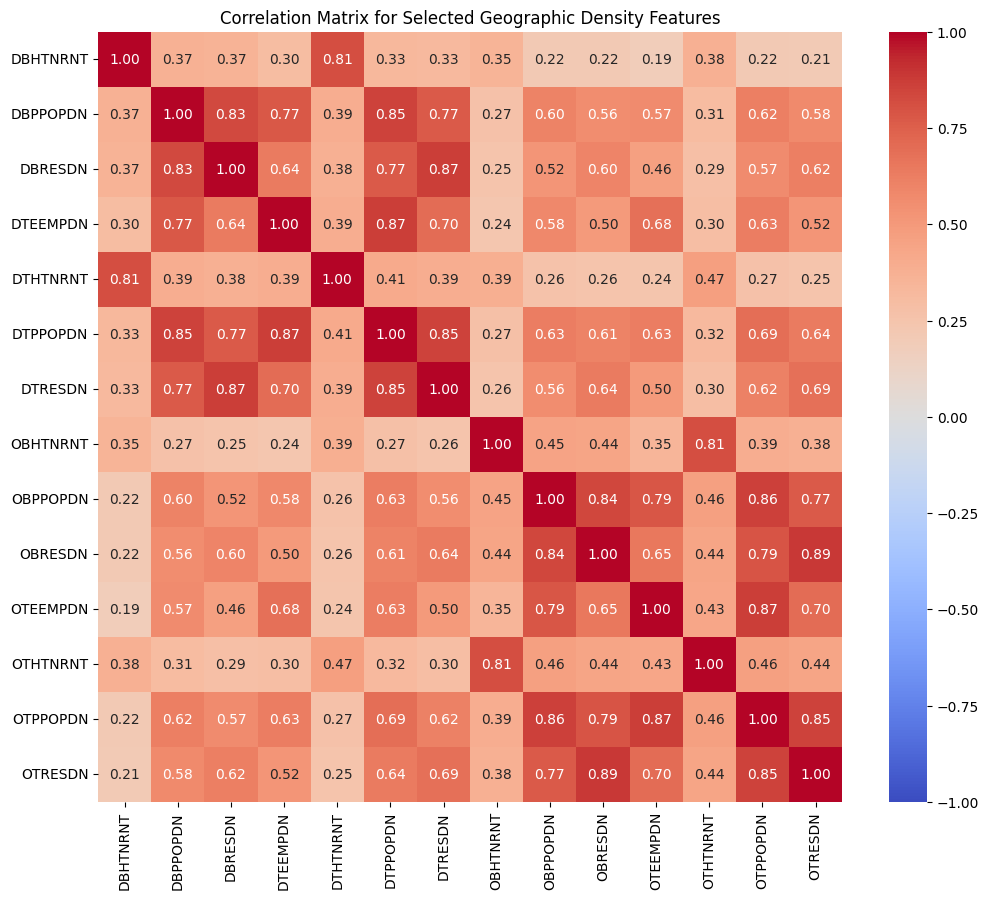

In [68]:
cols = [
    "DBHTNRNT", "DBPPOPDN", "DBRESDN", "DTEEMPDN", "DTHTNRNT", "DTPPOPDN", "DTRESDN",
    "OBHTNRNT", "OBPPOPDN", "OBRESDN", "OTEEMPDN", "OTHTNRNT", "OTPPOPDN", "OTRESDN"
]

corr_matrix = student_trips_filtered[cols].corr()
corr_matrix

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin = -1, vmax = 1)
plt.title("Correlation Matrix for Selected Geographic Density Features")
plt.show()


Our tree can handle some level of redundancy, but it seems we can safely drop all the block group level columns (since this information is often harder to get than tract-level information).

In [69]:
to_drop = [
    "DBHTNRNT", "DBPPOPDN", "DBRESDN",
    "OBHTNRNT", "OBPPOPDN", "OBRESDN",
]
student_trips_filtered = student_trips_filtered.drop(columns=to_drop)

Let's figure out how many outliers we have for SCHOOL_DISTANCE\.

In [70]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return len(outliers), len(outliers) / len(series) * 100

for var in ['SCHOOL_DISTANCE']:
    count, percent = count_outliers(student_trips_filtered[var])
    print(f"{var}: {count} outliers ({percent:.2f}% of total entries)")


SCHOOL_DISTANCE: 3945 outliers (15.06% of total entries)


We need to take care of the outliers for school distance. Let's visualize the breakdown of school bus users.

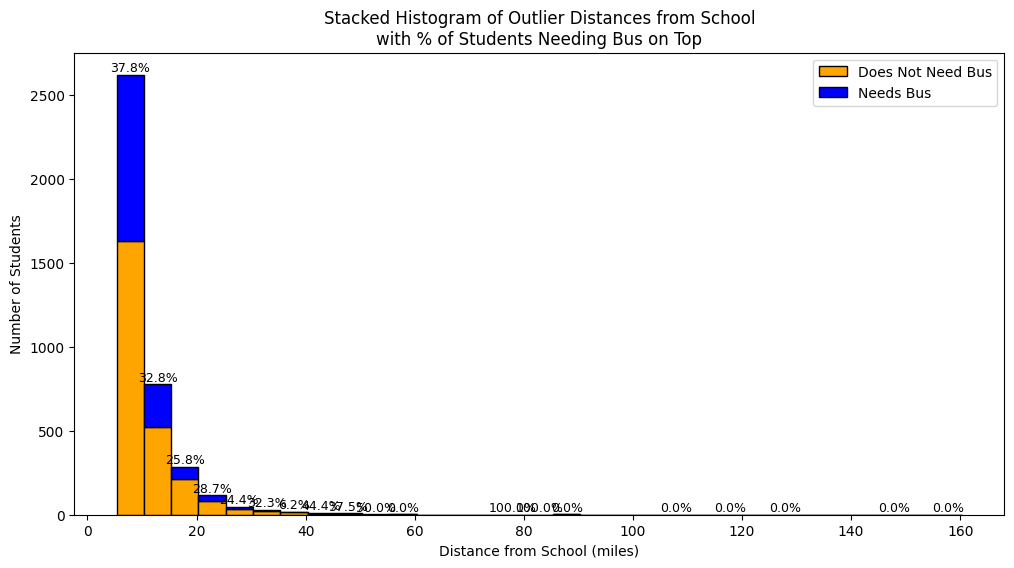

In [74]:
# Identify outliers using 1.5*IQR
Q1 = student_trips_filtered['SCHOOL_DISTANCE'].quantile(0.25)
Q3 = student_trips_filtered['SCHOOL_DISTANCE'].quantile(0.75)
IQR = Q3 - Q1
outliers = student_trips_filtered[student_trips_filtered['SCHOOL_DISTANCE'] > Q3 + 1.5*IQR]

# Only include distances ≤ 200 to be reasonable
outliers = outliers[outliers['SCHOOL_DISTANCE'] <= 200]

# Define bins
bins = np.arange(outliers['SCHOOL_DISTANCE'].min(), outliers['SCHOOL_DISTANCE'].max() + 5, 5)

# Compute counts per bin
counts_bus1, _ = np.histogram(outliers[outliers['NEEDS_SCHOOL_BUS']==1]['SCHOOL_DISTANCE'], bins=bins)
counts_bus0, _ = np.histogram(outliers[outliers['NEEDS_SCHOOL_BUS']==0]['SCHOOL_DISTANCE'], bins=bins)
counts_total = counts_bus1 + counts_bus0

# Plot stacked histogram
plt.figure(figsize=(12,6))
plt.bar(bins[:-1], counts_bus0, width=5, color='orange', label='Does Not Need Bus', align='edge', edgecolor='black')
plt.bar(bins[:-1], counts_bus1, width=5, bottom=counts_bus0, color='blue', label='Needs Bus', align='edge', edgecolor='black')

# Add percent labels
for i in range(len(bins)-1):
    if counts_total[i] > 0:
        pct = counts_bus1[i] / counts_total[i] * 100
        plt.text(bins[i] + 2.5, counts_total[i] + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.xlabel('Distance from School (miles)')
plt.ylabel('Number of Students')
plt.title('Stacked Histogram of Outlier Distances from School\nwith % of Students Needing Bus on Top')
plt.legend()
plt.show()


Filter out all outliers above 60 miles of distance from school since ~0% of these students used a bus (likely edge cases and unrepresentative trips).

In [75]:
# Remove rows where SCHOOL_DISTANCE > 60 miles
student_trips_filtered = student_trips_filtered[student_trips_filtered['SCHOOL_DISTANCE'] <= 60].reset_index(drop=True)


Let's check the correlations of some transformed versions of SCHOOL_DISTANCE with NEEDS_SCHOOL_BUS.

In [76]:
student_trips_filtered["LOG_DIST"] = np.log1p(student_trips_filtered["SCHOOL_DISTANCE"])
student_trips_filtered["SQRT_DIST"] = np.sqrt(student_trips_filtered["SCHOOL_DISTANCE"])
student_trips_filtered["SQUARE_DIST"] = student_trips_filtered["SCHOOL_DISTANCE"] ** 2


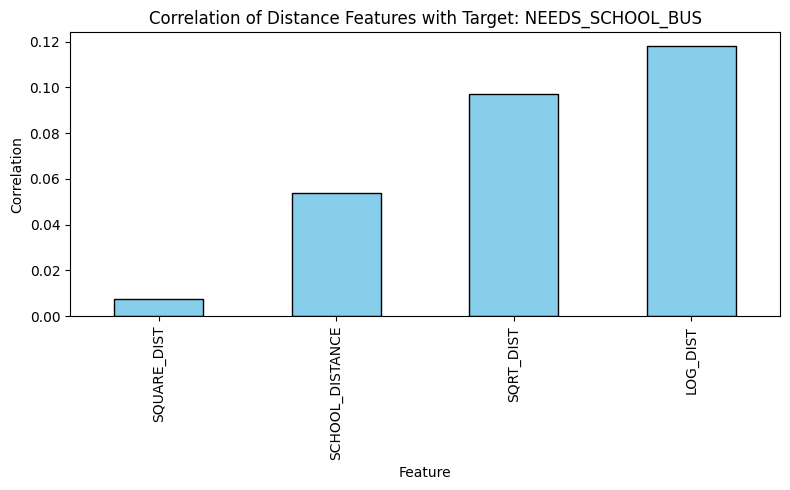

In [79]:
df = student_trips_filtered
target = "NEEDS_SCHOOL_BUS"

# Distance-related columns
distance_cols = ["LOG_DIST", "SQRT_DIST", "SQUARE_DIST", "SCHOOL_DISTANCE"]

# Compute correlation with the target for only these columns
corrs = df[distance_cols + [target]].corr()[target].drop(labels=[target])

# Sort by absolute value (strongest → weakest)
corrs_sorted = corrs.reindex(corrs.abs().sort_values(ascending=True).index)

# Plot
plt.figure(figsize=(8, 5))
corrs_sorted.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f"Correlation of Distance Features with Target: {target}")
plt.xlabel("Feature")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()



Clearly, LOG_DIST has the strongest correlation, so we can drop the remaining distance variables.

In [80]:
student_trips_filtered = student_trips_filtered.drop(columns=["SQRT_DIST", "SQUARE_DIST", "SCHOOL_DISTANCE"])

# **Training and Classification Pipeline**
We can infer that the geographic region of the US in question will largely influence the factors that determine school bus need. We want to force our model to choose "CENSUS_D" as its first split; the best way to do so is to simply make the split ourselves and train several smaller RFs on each "split dataset."

Let's seperate this data into smaller datasets, differentiated by region (Census Division). We will train a seperate RF on each sub-dataset.

In [142]:
# List of CENSUS_D columns
census_d_cols = {
    'New England':1,
    'Middle Atlantic':2,
    'East North Central':3,
    'West North Central':4,
    'South Atlantic':5,
    'East South Central':6,
    'West South Central':7,
    'Mountain':8,
    'Pacific':9
}

# Dictionary to store mini dataframes
mini_dfs = {}

# Iterate over each Census D column
for col in census_d_cols:
    # Select only rows where this category is 1
    subset = student_trips_filtered[student_trips_filtered["CENSUS_D"] == census_d_cols[col]].copy()

    # Drop all Census D columns
    subset = subset.drop(columns="CENSUS_D")

    # Store in dictionary
    mini_dfs[col] = subset
    print(subset.shape)

# Now mini_dfs contains a separate DataFrame for each Census D category
# Example access:
print("Number of rows in New England mini-df:", len(mini_dfs['New England']))


(362, 38)
(3399, 38)
(3029, 38)
(1027, 38)
(5582, 38)
(296, 38)
(6154, 38)
(975, 38)
(5351, 38)
Number of rows in New England mini-df: 362


Now, let's train a Random Forest on each of these mini datasets. We can use a threshold of 0.40 instead of 0.50 (to prioritize recall over precision, since it's better to falsely predict a kid needs a bus than falsely predict that they don't).

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Assume mini_dfs is the dictionary from your previous step
target_col = 'NEEDS_SCHOOL_BUS'

# Dictionary to store trained Random Forests
rf_models = {}

# Dictionary to store metrics
rf_metrics = {}

for census_cat, df in mini_dfs.items():
    print(f"\n=== Processing {census_cat} ===")

    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train-test split 80-20
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train RF
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # Store model
    rf_models[census_cat] = rf

    # Predictions
    y_prob = rf.predict_proba(X_test)[:, 1]  # for ROC-AUC
    y_pred = (y_prob >= 0.40).astype(int)   # apply threshold of 0.40

    train_prob = rf.predict_proba(X_train)[:, 1]
    print("Train ROC-AUC:", roc_auc_score(y_train, train_prob))
    print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


    # Metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_0': precision_score(y_test, y_pred, pos_label=0, zero_division=0),
        'precision_1': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        'recall_0': recall_score(y_test, y_pred, pos_label=0, zero_division=0),
        'recall_1': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        'f1_0': f1_score(y_test, y_pred, pos_label=0, zero_division=0),
        'f1_1': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        "y_pred_array": y_pred,
        "y_test_array": y_test.values,
        "y_prob_array": y_prob,
        "y_train_array": y_train.values,
        "y_train_prob_array": rf.predict_proba(X_train)[:, 1]
    }

    rf_metrics[census_cat] = metrics

    # Display metrics
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    print(f"Precision: 0={metrics['precision_0']:.3f}, 1={metrics['precision_1']:.3f}")
    print(f"Recall: 0={metrics['recall_0']:.3f}, 1={metrics['recall_1']:.3f}")
    print(f"F1-score: 0={metrics['f1_0']:.3f}, 1={metrics['f1_1']:.3f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])



=== Processing New England ===
Train ROC-AUC: 1.0
Test ROC-AUC: 0.6733993902439024
Accuracy: 0.603
ROC-AUC: 0.673
Precision: 0=0.658, 1=0.543
Recall: 0=0.610, 1=0.594
F1-score: 0=0.633, 1=0.567
Confusion Matrix:
[[25 16]
 [13 19]]

=== Processing Middle Atlantic ===
Train ROC-AUC: 0.9993013203051566
Test ROC-AUC: 0.7857729544580756
Accuracy: 0.719
ROC-AUC: 0.786
Precision: 0=0.765, 1=0.698
Recall: 0=0.542, 1=0.864
F1-score: 0=0.635, 1=0.772
Confusion Matrix:
[[166 140]
 [ 51 323]]

=== Processing East North Central ===
Train ROC-AUC: 0.9979327649091615
Test ROC-AUC: 0.8144933435494683
Accuracy: 0.754
ROC-AUC: 0.814
Precision: 0=0.823, 1=0.639
Recall: 0=0.792, 1=0.684
F1-score: 0=0.807, 1=0.661
Confusion Matrix:
[[312  82]
 [ 67 145]]

=== Processing West North Central ===
Train ROC-AUC: 0.9996442255062945
Test ROC-AUC: 0.7997835497835498
Accuracy: 0.791
ROC-AUC: 0.800
Precision: 0=0.849, 1=0.672
Recall: 0=0.843, 1=0.682
F1-score: 0=0.846, 1=0.677
Confusion Matrix:
[[118  22]
 [ 21  45

Let's figure out the overall metrics. We need special logic to combine the metrics of each individual RF for every Census Division into an "overall" set of metrics.

In [147]:
def show_stats(rf_metrics):

    import numpy as np
    from sklearn.metrics import roc_auc_score

    # Initialize accumulators
    total_samples = 0
    weighted_acc = 0
    weighted_precision_0 = 0
    weighted_precision_1 = 0
    weighted_recall_0 = 0
    weighted_recall_1 = 0
    weighted_f1_0 = 0
    weighted_f1_1 = 0
    total_conf_matrix = np.zeros((2,2), dtype=int)

    all_y_test = []
    all_y_prob = []
    all_y_train = []
    all_y_train_prob = []

    for cat, metrics in rf_metrics.items():
        n = metrics['confusion_matrix'].sum()  # total samples in this mini-test
        total_samples += n

        # Accuracy weighted
        weighted_acc += metrics['accuracy'] * n

        # Precision/recall/f1 weighted by number of class instances
        cm = metrics['confusion_matrix']
        n0 = cm[0,0] + cm[0,1]  # true class 0
        n1 = cm[1,0] + cm[1,1]  # true class 1

        weighted_precision_0 += metrics['precision_0'] * n0
        weighted_precision_1 += metrics['precision_1'] * n1
        weighted_recall_0 += metrics['recall_0'] * n0
        weighted_recall_1 += metrics['recall_1'] * n1
        weighted_f1_0 += metrics['f1_0'] * n0
        weighted_f1_1 += metrics['f1_1'] * n1

        # Confusion matrix sum
        total_conf_matrix += cm

        # Collect probs for ROC-AUC
        all_y_test.append(metrics.get('y_test_array'))
        all_y_prob.append(metrics.get('y_prob_array'))
        all_y_train.append(metrics.get('y_train_array'))
        all_y_train_prob.append(metrics.get('y_train_prob_array'))

    # Collect total class counts
    total_n0 = sum(m['confusion_matrix'][0,0]+m['confusion_matrix'][0,1] for m in rf_metrics.values())
    total_n1 = sum(m['confusion_matrix'][1,0]+m['confusion_matrix'][1,1] for m in rf_metrics.values())

    overall_metrics = {
        'accuracy': weighted_acc / total_samples,
        'precision_0': weighted_precision_0 / total_n0,
        'precision_1': weighted_precision_1 / total_n1,
        'recall_0': weighted_recall_0 / total_n0,
        'recall_1': weighted_recall_1 / total_n1,
        'f1_0': weighted_f1_0 / total_n0,
        'f1_1': weighted_f1_1 / total_n1,
        'train_roc_auc': roc_auc_score(np.concatenate(all_y_train), np.concatenate(all_y_train_prob)),
        'test_roc_auc': roc_auc_score(np.concatenate(all_y_test), np.concatenate(all_y_prob)),
        'confusion_matrix': total_conf_matrix
    }

    for i in overall_metrics:
        print(i, ":", overall_metrics[i])


Check metrics.

In [136]:
show_stats(rf_metrics)

accuracy : 0.7963351784691735
precision_0 : 0.853101273912301
precision_1 : 0.6588532329584507
recall_0 : 0.8499452354874042
recall_1 : 0.6729678638941399
f1_0 : 0.8495014759753476
f1_1 : 0.6597829347108644
train_roc_auc : 0.9993429089649566
test_roc_auc : 0.8374317859166518
confusion_matrix : [[3104  548]
 [ 519 1068]]


Immediately, it's obvious that the models are highly overfit. The Train ROC-AUC is far higher than the test ROC-AUC. Overfitting is highly likely considering some of our mini datasets are extremely small (less than 1k rows). Let's change some features (including tree depth and class balancing) for each tree and try again.

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np

target_col = "NEEDS_SCHOOL_BUS"

new_rf_models = {}
new_rf_metrics = {}

for census_cat, df in mini_dfs.items():
    print(f"\n=== Processing {census_cat} ({len(df)} rows) ===")

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Dynamic RF parameters
    n_rows = len(X_train)
    if n_rows < 1000:
        max_depth, min_samples_leaf, n_estimators = 8, 2, 300
    elif n_rows < 5000:
        max_depth, min_samples_leaf, n_estimators = 10, 2, 400
    else:
        max_depth, min_samples_leaf, n_estimators = 12, 1, 500

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=5,
        max_features="sqrt",
        class_weight="balanced",
        random_state=42
    )

    rf.fit(X_train, y_train)

    # Predictions
    y_train_prob = rf.predict_proba(X_train)[:,1]
    y_test_prob = rf.predict_proba(X_test)[:,1]

    y_train_pred = (y_train_prob >= 0.40).astype(int)
    y_test_pred = (y_test_prob >= 0.40).astype(int)

    metrics = {
        "y_train_array": y_train.values,
        "y_train_prob_array": y_train_prob,
        "y_pred_array": y_test_pred,
        "y_test_array": y_test.values,
        "y_prob_array": y_test_prob,
        "train_roc_auc": roc_auc_score(y_train, y_train_prob),
        "test_roc_auc": roc_auc_score(y_test, y_test_prob),
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision_0": precision_score(y_test, y_test_pred, pos_label=0, zero_division=0),
        "precision_1": precision_score(y_test, y_test_pred, pos_label=1, zero_division=0),
        "recall_0": recall_score(y_test, y_test_pred, pos_label=0, zero_division=0),
        "recall_1": recall_score(y_test, y_test_pred, pos_label=1, zero_division=0),
        "f1_0": f1_score(y_test, y_test_pred, pos_label=0, zero_division=0),
        "f1_1": f1_score(y_test, y_test_pred, pos_label=1, zero_division=0),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred)
    }

    new_rf_models[census_cat] = rf
    new_rf_metrics[census_cat] = metrics

    # Display
    print(f"Train ROC-AUC: {metrics['train_roc_auc']:.3f}")
    print(f"Test ROC-AUC: {metrics['test_roc_auc']:.3f}")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: 0={metrics['precision_0']:.3f}, 1={metrics['precision_1']:.3f}")
    print(f"Recall: 0={metrics['recall_0']:.3f}, 1={metrics['recall_1']:.3f}")
    print(f"F1-score: 0={metrics['f1_0']:.3f}, 1={metrics['f1_1']:.3f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])



=== Processing New England (362 rows) ===
Train ROC-AUC: 0.947
Test ROC-AUC: 0.649
Accuracy: 0.603
Precision: 0=0.731, 1=0.532
Recall: 0=0.463, 1=0.781
F1-score: 0=0.567, 1=0.633
Confusion Matrix:
[[19 22]
 [ 7 25]]

=== Processing Middle Atlantic (3399 rows) ===
Train ROC-AUC: 0.895
Test ROC-AUC: 0.730
Accuracy: 0.669
Precision: 0=0.765, 1=0.641
Recall: 0=0.382, 1=0.904
F1-score: 0=0.510, 1=0.750
Confusion Matrix:
[[117 189]
 [ 36 338]]

=== Processing East North Central (3029 rows) ===
Train ROC-AUC: 0.907
Test ROC-AUC: 0.768
Accuracy: 0.614
Precision: 0=0.885, 1=0.472
Recall: 0=0.467, 1=0.887
F1-score: 0=0.611, 1=0.616
Confusion Matrix:
[[184 210]
 [ 24 188]]

=== Processing West North Central (1027 rows) ===
Train ROC-AUC: 0.937
Test ROC-AUC: 0.731
Accuracy: 0.631
Precision: 0=0.840, 1=0.455
Recall: 0=0.564, 1=0.773
F1-score: 0=0.675, 1=0.573
Confusion Matrix:
[[79 61]
 [15 51]]

=== Processing South Atlantic (5582 rows) ===
Train ROC-AUC: 0.867
Test ROC-AUC: 0.729
Accuracy: 0.595

In [138]:
show_stats(rf_metrics)

accuracy : 0.7963351784691735
precision_0 : 0.853101273912301
precision_1 : 0.6588532329584507
recall_0 : 0.8499452354874042
recall_1 : 0.6729678638941399
f1_0 : 0.8495014759753476
f1_1 : 0.6597829347108644
train_roc_auc : 0.9993429089649566
test_roc_auc : 0.8374317859166518
confusion_matrix : [[3104  548]
 [ 519 1068]]


In [139]:
show_stats(new_rf_metrics)

accuracy : 0.6361901126169116
precision_0 : 0.879776904116466
precision_1 : 0.4707013936517885
recall_0 : 0.5473713033953997
recall_1 : 0.8405797101449275
f1_0 : 0.6668726649248082
f1_1 : 0.5978123404548121
train_roc_auc : 0.9111719929626834
test_roc_auc : 0.7757835776858939
confusion_matrix : [[1999 1653]
 [ 253 1334]]


The "less overfit" model is performing worse; this is an indicator that our signal is simply weak in the dataset, which makes sense, since the intended use of this dataset was different.

In [146]:
student_trips_filtered.columns

Index(['DTEEMPDN', 'DTHTNRNT', 'DTPPOPDN', 'DTRESDN', 'OTEEMPDN', 'OTHTNRNT',
       'OTPPOPDN', 'OTRESDN', 'CENSUS_D', 'URBRUR', 'NEEDS_SCHOOL_BUS',
       'HHFAMINC_Less than $10,000', 'HHFAMINC_$10,000 to $14,999',
       'HHFAMINC_$15,000 to $24,999', 'HHFAMINC_$25,000 to $34,999',
       'HHFAMINC_$35,000 to $49,999', 'HHFAMINC_$50,000 to $74,999',
       'HHFAMINC_$75,000 to $99,999', 'HHFAMINC_$100,000 to $124,999',
       'HHFAMINC_$125,000 to $149,999', 'HHFAMINC_$150,000 to $199,999',
       'HHFAMINC_$200,000 or more', 'HH_RACE_White',
       'HH_RACE_Black or African American', 'HH_RACE_Asian',
       'HH_RACE_American Indian or Alaska Native',
       'HH_RACE_Native Hawaiian or other Pacific Islander',
       'MSASIZE_In an MSA of Less than 250,000',
       'MSASIZE_In an MSA of 250,000 - 499,999',
       'MSASIZE_In an MSA of 500,000 - 999,999',
       'MSASIZE_In an MSA or CMSA of 1,000,000 - 2,999,999',
       'MSASIZE_In an MSA or CMSA of 3 million or more',
       'MS

Let's save the dataset.

In [148]:
#Save the dataframe as CSV
student_trips_filtered.to_csv('2017_Final.csv', index=False)
from google.colab import files
files.download('2017_Final.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>